# NFL Big Data Bowl 2026 - Deep Analysis: Play Outcomes

This notebook performs advanced analysis by merging all data sources to understand:
1. **Complete vs Incomplete passes** - What differentiates success?
2. **Situational factors** - Down, distance, quarter effects
3. **Player movement signatures** - Do successful plays have distinct convergence patterns?
4. **Predictive patterns** - Can we identify success indicators?

**Data Sources**:
- Input/Output tracking data (player movements)
- Supplementary data (play outcomes, down/distance, etc.)
- Convergence metrics (from analysis notebook)

## Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load and Merge All Data Sources

In [5]:
# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
COMPETITION_DIR = DATA_DIR / '114239_nfl_competition_files_published_analytics_final'
OUTPUT_DIR = PROCESSED_DIR / 'deep_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

print("Loading data sources...")
print("="*80)

# 1. Load convergence metrics
convergence_df = pd.read_csv(PROCESSED_DIR / 'convergence_speed_all_plays.csv')
print(f"✓ Convergence metrics: {len(convergence_df):,} rows")

# 2. Load supplementary data
supp_data = pd.read_csv(COMPETITION_DIR / 'supplementary_data.csv')
print(f"✓ Supplementary data: {len(supp_data):,} rows")

print(f"\nSupplementary data columns:")
for col in supp_data.columns:
    print(f"  • {col}")

Loading data sources...
✓ Convergence metrics: 173,150 rows
✓ Supplementary data: 18,009 rows

Supplementary data columns:
  • game_id
  • season
  • week
  • game_date
  • game_time_eastern
  • home_team_abbr
  • visitor_team_abbr
  • play_id
  • play_description
  • quarter
  • game_clock
  • down
  • yards_to_go
  • possession_team
  • defensive_team
  • yardline_side
  • yardline_number
  • pre_snap_home_score
  • pre_snap_visitor_score
  • play_nullified_by_penalty
  • pass_result
  • pass_length
  • offense_formation
  • receiver_alignment
  • route_of_targeted_receiver
  • play_action
  • dropback_type
  • dropback_distance
  • pass_location_type
  • defenders_in_the_box
  • team_coverage_man_zone
  • team_coverage_type
  • penalty_yards
  • pre_penalty_yards_gained
  • yards_gained
  • expected_points
  • expected_points_added
  • pre_snap_home_team_win_probability
  • pre_snap_visitor_team_win_probability
  • home_team_win_probability_added
  • visitor_team_win_probility_added

In [9]:
# Explore supplementary data structure
print("\n" + "="*80)
print("SUPPLEMENTARY DATA PREVIEW")
print("="*80)
print(f"\nShape: {supp_data.shape}")
print(f"\nSample data:")
supp_data.head(10)


SUPPLEMENTARY DATA PREVIEW

Shape: (18009, 41)

Sample data:


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,pass_result,pass_length,offense_formation,receiver_alignment,route_of_targeted_receiver,play_action,dropback_type,dropback_distance,pass_location_type,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,10:46,3,12,DET,KC,DET,23,20,14,N,C,18,EMPTY,3x2,IN,False,TRADITIONAL,5.30,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,07:30,1,10,DET,KC,DET,34,0,0,N,C,13,SINGLEBACK,3x1,POST,True,TRADITIONAL,4.72,INSIDE_BOX,7,ZONE_COVERAGE,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,00:09,2,10,DET,KC,DET,42,14,7,N,I,18,SHOTGUN,3x1,OUT,False,TRADITIONAL,4.44,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,00:45,1,10,KC,DET,DET,30,7,7,N,C,23,SHOTGUN,3x1,CORNER,False,TRADITIONAL,5.36,INSIDE_BOX,5,ZONE_COVERAGE,COVER_2_ZONE,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,01:54,1,10,KC,DET,KC,43,7,7,N,I,38,SHOTGUN,2x2,POST,False,TRADITIONAL,4.59,INSIDE_BOX,6,ZONE_COVERAGE,COVER_4_ZONE,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061
5,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,101,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.049720,-0.049720
6,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3566,(8:31) J.Goff pass short right to J.Reynolds t...,4,08:31,1,10,DET,KC,KC,47,20,14,N,C,15,I_FORM,2x1,HITCH,True,TRADITIONAL,7.37,INSIDE_BOX,7,MAN_COVERAGE,COVER_1_MAN,NaN,33,33,2.974547,2.122270,0.739288,0.260712,-0.099454,0.099454
7,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,902,(13:54) (Shotgun) P.Mahomes pass incomplete sh...,2,13:54,1,10,KC,DET,DET,25,0,7,N,I,4,SHOTGUN,3x1,HITCH,False,TRADITIONAL,2.85,INSIDE_BOX,6,MAN_COVERAGE,COVER_1_MAN,NaN,0,0,4.405786,-0.407670,0.490896,0.509104,-0.011206,0.011206
8,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1069,(11:50) J.Goff pass short middle to B.Wright t...,2,11:50,1,10,DET,KC,DET,25,7,7,N,C,5,SINGLEBACK,3x1,IN,False,TRADITIONAL,4.89,INSIDE_BOX,7,ZONE_COVERAGE,COVER_3_ZONE,NaN,9,9,1.347074,0.566854,0.554222,0.445778,-0.016984,0.016984
9,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,2261,(12:31) (Shotgun) J.Goff pass short left to S....,3,12:31,3,10,DET,KC,DET,7,14,7,N,C,3,SHOTGUN,3x1,CROSS,False,TRADITIONAL,4.76,INSIDE_BOX,5,MAN_COVERAGE,COVER_1_MAN,NaN,4,4,-1.290895,-1.334247,0.833186,0.166814,0.020599,-0.020599


In [21]:
print(supp_data['team_coverage_man_zone'].value_counts())
print('='*80)
print(supp_data['team_coverage_type'].value_counts())
print('='*80)
print(supp_data['dropback_type'].value_counts())

team_coverage_man_zone
ZONE_COVERAGE    12783
MAN_COVERAGE      5221
Name: count, dtype: int64
team_coverage_type
COVER_3_ZONE    5664
COVER_1_MAN     4108
COVER_4_ZONE    2860
COVER_2_ZONE    2518
COVER_6_ZONE    1693
COVER_0_MAN      781
COVER_2_MAN      332
PREVENT           48
Name: count, dtype: int64
dropback_type
TRADITIONAL               15922
SCRAMBLE                    859
DESIGNED_ROLLOUT_RIGHT      697
DESIGNED_ROLLOUT_LEFT       405
SCRAMBLE_ROLLOUT_RIGHT      108
SCRAMBLE_ROLLOUT_LEFT        17
Name: count, dtype: int64


In [6]:
# Check what play outcome information is available
print("\nAvailable play outcome information:")
print("="*80)

# Look for columns related to play outcomes
outcome_cols = [col for col in supp_data.columns if any(word in col.lower() 
                for word in ['pass', 'result', 'complete', 'outcome', 'yards', 'down', 'distance', 'quarter'])]

print(f"\nOutcome-related columns found: {len(outcome_cols)}")
for col in outcome_cols:
    n_unique = supp_data[col].nunique()
    print(f"  • {col}: {n_unique} unique values")
    if n_unique < 20:
        print(f"    Values: {supp_data[col].unique()[:10]}")


Available play outcome information:

Outcome-related columns found: 10
  • quarter: 5 unique values
    Values: [4 1 2 3 5]
  • down: 4 unique values
    Values: [3 1 2 4]
  • yards_to_go: 34 unique values
  • pass_result: 3 unique values
    Values: ['C' 'I' 'IN']
  • pass_length: 70 unique values
  • dropback_distance: 974 unique values
  • pass_location_type: 4 unique values
    Values: ['INSIDE_BOX' 'OUTSIDE_RIGHT' 'OUTSIDE_LEFT' nan 'UNKNOWN']
  • penalty_yards: 21 unique values
  • pre_penalty_yards_gained: 95 unique values
  • yards_gained: 97 unique values


In [22]:
# Merge convergence data with supplementary data
print("\nMerging datasets...")
print("="*80)

# Identify common columns for merging
common_cols = list(set(convergence_df.columns).intersection(set(supp_data.columns)))
print(f"\nCommon columns for merging: {common_cols}")

# Merge on game_id and play_id
if 'game_id' in common_cols and 'play_id' in common_cols:
    merged_df = convergence_df.merge(
        supp_data,
        on=['game_id', 'play_id'],
        how='left',
        suffixes=('', '_supp')
    )
    
    print(f"\n✓ Merged successfully!")
    print(f"  Original convergence rows: {len(convergence_df):,}")
    print(f"  Merged rows: {len(merged_df):,}")
    print(f"  New columns added: {len(merged_df.columns) - len(convergence_df.columns)}")
    
    # Check merge quality
    merge_success_rate = (merged_df[outcome_cols[0]].notna().sum() / len(merged_df) * 100) if outcome_cols else 0
    print(f"  Merge success rate: {merge_success_rate:.1f}%")
else:
    print("\n⚠️ Cannot merge - need to identify correct join keys")
    print("Convergence columns:", convergence_df.columns.tolist()[:10])
    print("Supplementary columns:", supp_data.columns.tolist()[:10])


Merging datasets...

Common columns for merging: ['play_id', 'week', 'game_id']

✓ Merged successfully!
  Original convergence rows: 173,150
  Merged rows: 173,150
  New columns added: 39
  Merge success rate: 100.0%


In [23]:
merged_df.head()

,week,game_id,play_id,nfl_id,player_role,player_position,initial_distance,final_distance,min_distance,distance_change,time_elapsed,convergence_speed,avg_speed,max_speed,num_frames,season,week_supp,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,pass_result,pass_length,offense_formation,receiver_alignment,route_of_targeted_receiver,play_action,dropback_type,dropback_distance,pass_location_type,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,1,2023090700,101,54527,Defensive Coverage,FS,38.734099,36.314143,36.314143,-2.419957,2.6,0.930753,2.026538,3.68,26,2023,1,09/07/2023,20:20:00,KC,DET,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
1,1,2023090700,101,46137,Defensive Coverage,SS,24.078863,19.375388,19.375388,-4.703475,2.6,1.809029,2.212308,5.34,26,2023,1,09/07/2023,20:20:00,KC,DET,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
2,1,2023090700,101,52546,Defensive Coverage,CB,22.288868,19.820143,19.820143,-2.468725,2.6,0.949510,1.910000,3.17,26,2023,1,09/07/2023,20:20:00,KC,DET,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
3,1,2023090700,101,53487,Defensive Coverage,MLB,33.570587,26.305413,26.305413,-7.265174,2.6,2.794298,2.965000,5.49,26,2023,1,09/07/2023,20:20:00,KC,DET,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
4,1,2023090700,101,54486,Defensive Coverage,CB,44.243102,44.342922,44.243102,0.099821,2.6,-0.038393,2.556923,4.83,26,2023,1,09/07/2023,20:20:00,KC,DET,(14:25) (Shotgun) J.Goff pass incomplete deep ...,1,14:25,3,3,DET,KC,DET,32,0,0,N,I,22,SHOTGUN,2x2,CORNER,False,TRADITIONAL,2.13,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972


## 2. Identify Play Outcomes

Determine which plays were complete vs incomplete passes

In [24]:
# Assuming merged_df exists, let's identify pass outcomes
# This will depend on what columns are actually in supplementary_data
# Common column names: 'passResult', 'play_description', 'isComplete', etc.

print("Identifying play outcomes...")
print("="*80)

# Search for pass result column
pass_result_cols = [col for col in merged_df.columns if 'pass' in col.lower() and 
                   any(word in col.lower() for word in ['result', 'complete', 'outcome'])]

print(f"\nPotential pass result columns: {pass_result_cols}")

if pass_result_cols:
    result_col = pass_result_cols[0]
    print(f"\nUsing column: '{result_col}'")
    print(f"\nUnique values:")
    print(merged_df[result_col].value_counts())
    
    # Create binary outcome column
    # Adjust this based on actual values in your data
    merged_df['pass_complete'] = merged_df[result_col].isin(['C', 'Complete', 'complete', 1, True])
    
    print(f"\nPass completion breakdown:")
    print(merged_df.groupby('pass_complete').size())
else:
    print("\n⚠️ No clear pass result column found. Will need manual identification.")
    print("\nAvailable columns that might help:")
    for col in merged_df.columns:
        if any(word in col.lower() for word in ['desc', 'result', 'outcome', 'yards']):
            print(f"  • {col}")
print(f"\nColumn: {result_col} - Contextual information:\nC: Complete pass, \nI: Incomplete pass, \nS: Quarterback sack, \nIN: Intercepted pass, \nR: Scramble")

Identifying play outcomes...

Potential pass result columns: ['pass_result']

Using column: 'pass_result'

Unique values:
pass_result
C     119872
I      49145
IN      4133
Name: count, dtype: int64

Pass completion breakdown:
pass_complete
False     53278
True     119872
dtype: int64

Column: pass_result - Contextual information:
C: Complete pass, 
I: Incomplete pass, 
S: Quarterback sack, 
IN: Intercepted pass, 
R: Scramble


In [10]:
# Extract situational variables
print("\nExtracting situational variables...")
print("="*80)

situational_vars = {}

# Down
down_cols = [col for col in merged_df.columns if 'down' in col.lower()]
if down_cols:
    situational_vars['down'] = down_cols[0]
    print(f"✓ Down: {down_cols[0]}")
    print(f"  Values: {sorted(merged_df[down_cols[0]].dropna().unique())}")

# Distance
dist_cols = [col for col in merged_df.columns if 'distance' in col.lower() or 'togo' in col.lower()]
if dist_cols:
    situational_vars['yards_to_go'] = dist_cols[0]
    print(f"✓ Yards to go: {dist_cols[0]}")
    print(f"  Range: {merged_df[dist_cols[0]].min()} - {merged_df[dist_cols[0]].max()}")

# Quarter
quarter_cols = [col for col in merged_df.columns if 'quarter' in col.lower()]
if quarter_cols:
    situational_vars['quarter'] = quarter_cols[0]
    print(f"✓ Quarter: {quarter_cols[0]}")
    print(f"  Values: {sorted(merged_df[quarter_cols[0]].dropna().unique())}")

# Yards gained
yards_cols = [col for col in merged_df.columns if 'yards' in col.lower() and 'gain' in col.lower()]
if yards_cols:
    situational_vars['yards_gained'] = yards_cols[0]
    print(f"✓ Yards gained: {yards_cols[0]}")

print(f"\n✓ Found {len(situational_vars)} situational variables")


Extracting situational variables...
✓ Down: down
  Values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
✓ Yards to go: initial_distance
  Range: 0.0509895667184146 - 71.19643696349951
✓ Quarter: quarter
  Values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
✓ Yards gained: pre_penalty_yards_gained

✓ Found 4 situational variables


## 3. Compare Complete vs Incomplete Passes

Analyze convergence patterns for successful vs unsuccessful passes

In [26]:
# Assuming we have 'pass_complete' column
if 'pass_complete' in merged_df.columns:
    complete = merged_df[merged_df['pass_complete'] == True]
    incomplete = merged_df[merged_df['pass_complete'] == False]
    
    print("="*80)
    print("COMPLETE VS INCOMPLETE PASSES - CONVERGENCE COMPARISON")
    print("="*80)
    
    print(f"\nComplete passes: {len(complete):,} player instances")
    print(f"Incomplete passes: {len(incomplete):,} player instances")
    
    # Compare by role
    roles = ['Defensive Coverage', 'Targeted Receiver']
    
    for role in roles:
        complete_role = complete[complete['player_role'] == role]
        incomplete_role = incomplete[incomplete['player_role'] == role]
        
        if len(complete_role) > 0 and len(incomplete_role) > 0:
            print(f"\n{role}:")
            print(f"  Complete passes:")
            print(f"    Avg convergence: {complete_role['convergence_speed'].mean():.2f} yd/s")
            print(f"    Avg final distance: {complete_role['final_distance'].mean():.2f} yards")
            print(f"    Avg min distance: {complete_role['min_distance'].mean():.2f} yards")
            
            print(f"  Incomplete passes:")
            print(f"    Avg convergence: {incomplete_role['convergence_speed'].mean():.2f} yd/s")
            print(f"    Avg final distance: {incomplete_role['final_distance'].mean():.2f} yards")
            print(f"    Avg min distance: {incomplete_role['min_distance'].mean():.2f} yards")
            
            # Statistical test
            t_stat, p_value = stats.ttest_ind(
                complete_role['convergence_speed'].dropna(),
                incomplete_role['convergence_speed'].dropna()
            )
            print(f"  Statistical significance: p-value = {p_value:.10f} {'(SIGNIFICANT)' if p_value < 0.05 else '(not significant)'}")
else:
    print("⚠️ Need to create 'pass_complete' column first based on available data")

COMPLETE VS INCOMPLETE PASSES - CONVERGENCE COMPARISON

Complete passes: 119,872 player instances
Incomplete passes: 53,278 player instances

Defensive Coverage:
  Complete passes:
    Avg convergence: -0.40 yd/s
    Avg final distance: 17.99 yards
    Avg min distance: 15.49 yards
  Incomplete passes:
    Avg convergence: 0.18 yd/s
    Avg final distance: 20.28 yards
    Avg min distance: 18.50 yards
  Statistical significance: p-value = 0.0000000000 (SIGNIFICANT)

Targeted Receiver:
  Complete passes:
    Avg convergence: 2.92 yd/s
    Avg final distance: 5.49 yards
    Avg min distance: 5.38 yards
  Incomplete passes:
    Avg convergence: 3.32 yd/s
    Avg final distance: 9.62 yards
    Avg min distance: 9.51 yards
  Statistical significance: p-value = 0.0000000000 (SIGNIFICANT)


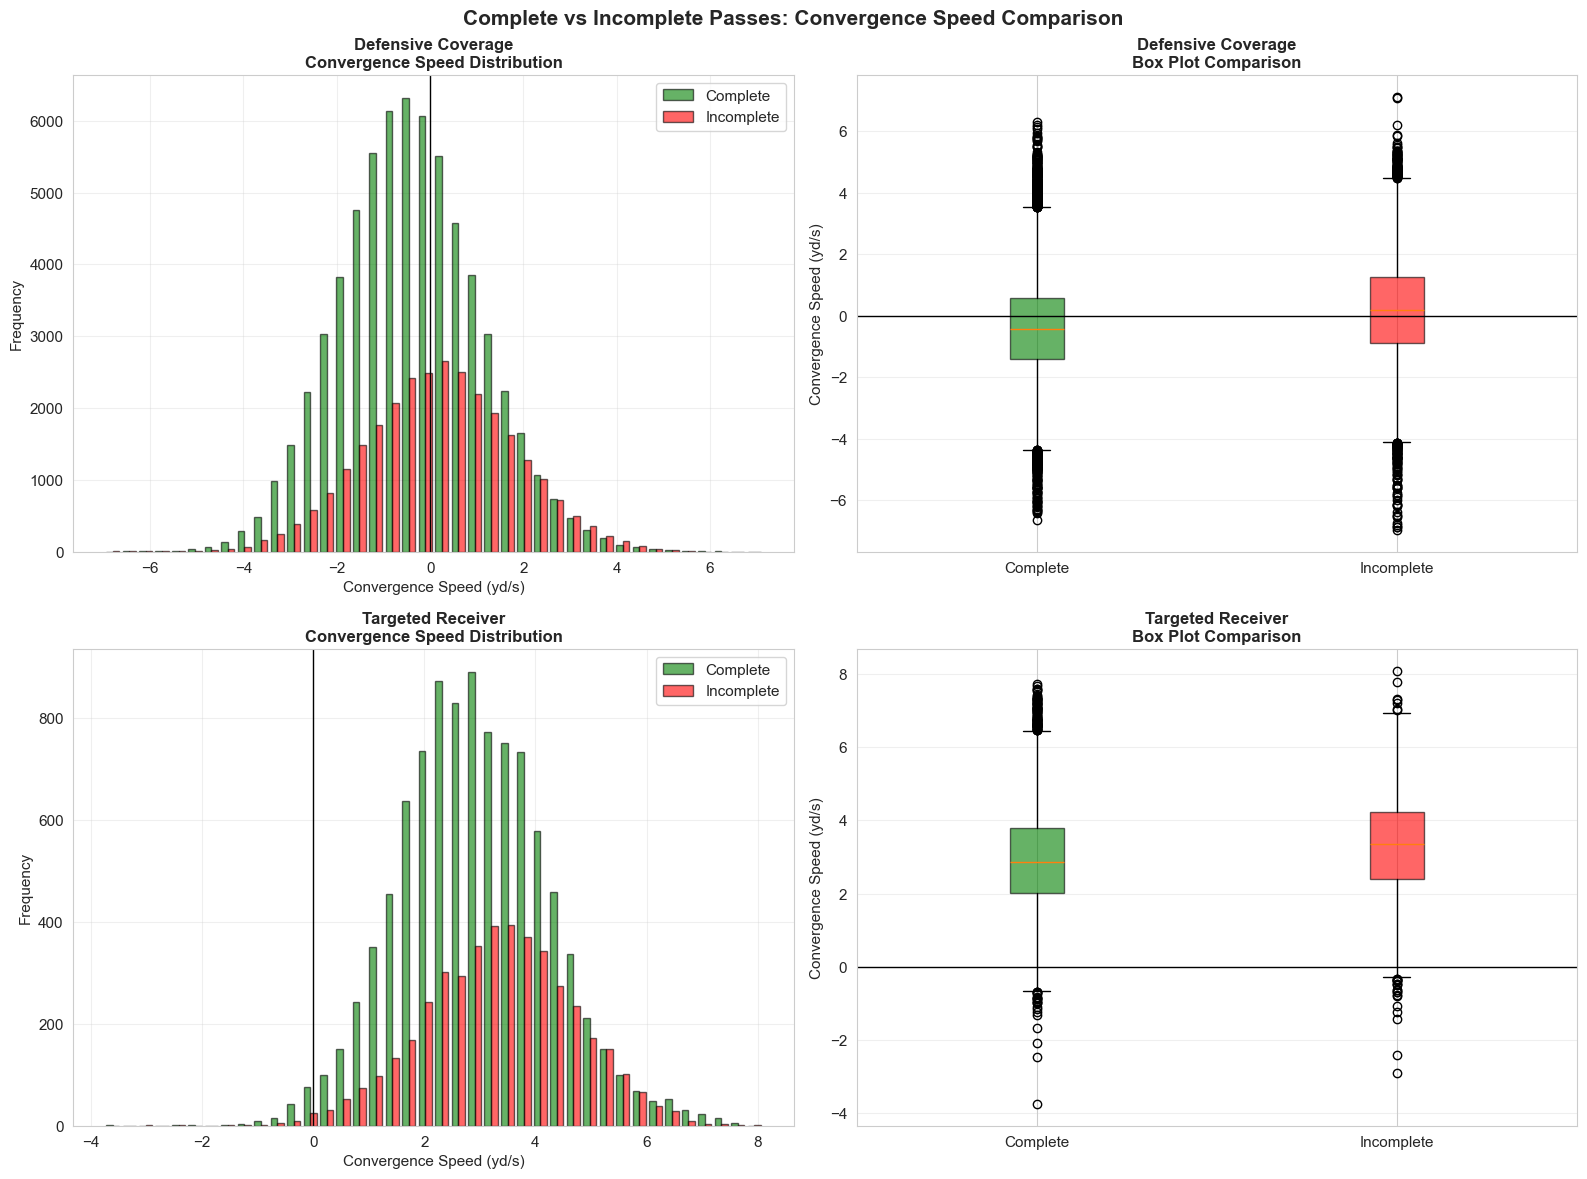

✅ Figure saved!


In [27]:
# Visualize complete vs incomplete
if 'pass_complete' in merged_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    roles = ['Defensive Coverage', 'Targeted Receiver']
    
    for idx, role in enumerate(roles):
        role_data = merged_df[merged_df['player_role'] == role]
        complete_role = role_data[role_data['pass_complete'] == True]
        incomplete_role = role_data[role_data['pass_complete'] == False]
        
        # Distribution comparison
        ax = axes[idx, 0]
        ax.hist([complete_role['convergence_speed'], incomplete_role['convergence_speed']],
               bins=40, label=['Complete', 'Incomplete'],
               color=['green', 'red'], alpha=0.6, edgecolor='black')
        ax.axvline(0, color='black', linestyle='-', linewidth=1)
        ax.set_xlabel('Convergence Speed (yd/s)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{role}\nConvergence Speed Distribution', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # Box plot comparison
        ax = axes[idx, 1]
        data_to_plot = [complete_role['convergence_speed'].dropna(),
                       incomplete_role['convergence_speed'].dropna()]
        bp = ax.boxplot(data_to_plot, labels=['Complete', 'Incomplete'],
                       patch_artist=True)
        bp['boxes'][0].set_facecolor('green')
        bp['boxes'][1].set_facecolor('red')
        for box in bp['boxes']:
            box.set_alpha(0.6)
        
        ax.axhline(0, color='black', linestyle='-', linewidth=1)
        ax.set_ylabel('Convergence Speed (yd/s)', fontsize=11)
        ax.set_title(f'{role}\nBox Plot Comparison', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3, axis='y')
    
    plt.suptitle('Complete vs Incomplete Passes: Convergence Speed Comparison',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'complete_vs_incomplete_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Figure saved!")

## 4. Situational Analysis

How do down, distance, and other factors affect convergence and success?

ANALYSIS BY DOWN

       Avg Convergence Speed  Completion Rate  N Plays
down                                                 
1                    -0.247            0.722    34541
2                    -0.278            0.704    31625
3                    -0.135            0.649    25735
4                    -0.018            0.569     2392


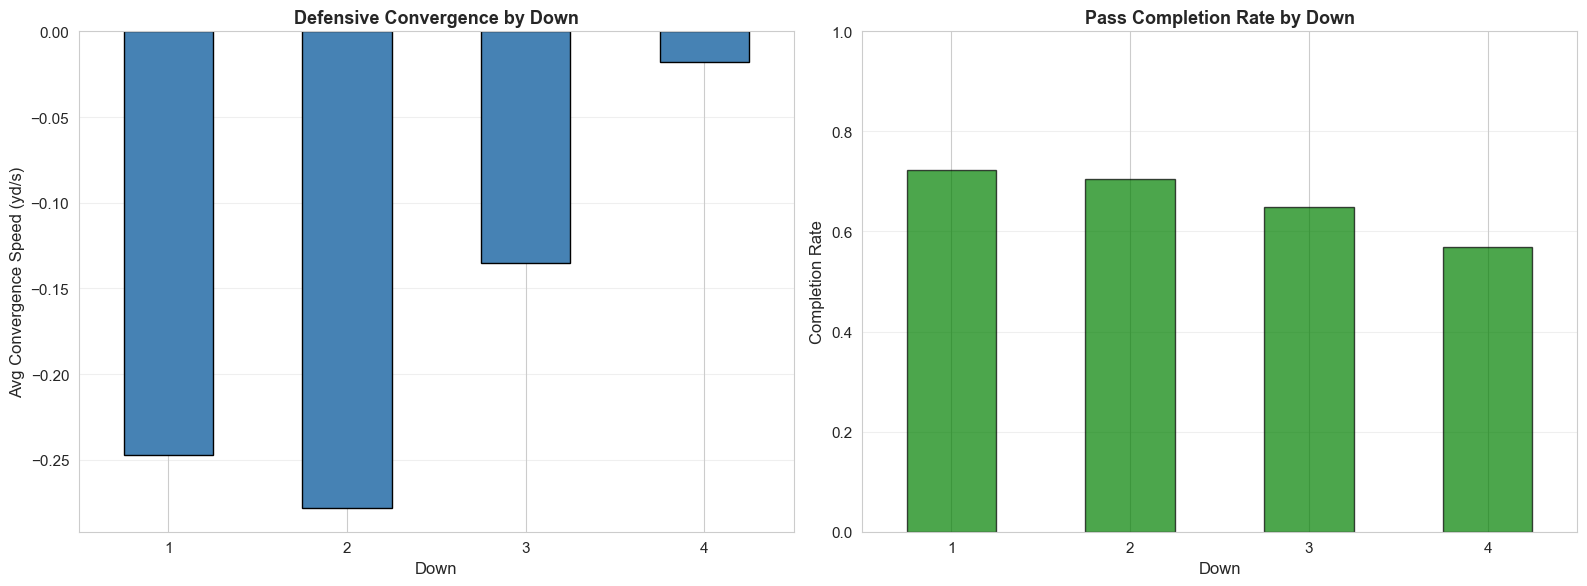


✅ Figure saved!


In [28]:
# Analyze by down
if 'down' in situational_vars and 'pass_complete' in merged_df.columns:
    down_col = situational_vars['down']
    
    print("="*80)
    print("ANALYSIS BY DOWN")
    print("="*80)
    
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    
    down_analysis = defenders.groupby(down_col).agg({
        'convergence_speed': 'mean',
        'pass_complete': ['mean', 'count']
    }).round(3)
    
    down_analysis.columns = ['Avg Convergence Speed', 'Completion Rate', 'N Plays']
    print("\n", down_analysis)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Convergence by down
    ax = axes[0]
    down_analysis['Avg Convergence Speed'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Down', fontsize=12)
    ax.set_ylabel('Avg Convergence Speed (yd/s)', fontsize=12)
    ax.set_title('Defensive Convergence by Down', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=0)
    
    # Completion rate by down
    ax = axes[1]
    down_analysis['Completion Rate'].plot(kind='bar', ax=ax, color='green', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Down', fontsize=12)
    ax.set_ylabel('Completion Rate', fontsize=12)
    ax.set_title('Pass Completion Rate by Down', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'analysis_by_down.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Figure saved!")

ANALYSIS BY YARDS TO GO

                    Avg Convergence  Avg Min Dist  Completion Rate  N Plays
distance_category                                                         
Short (0-3)                 -1.661         1.699            0.762     2582
Medium (4-7)                -0.953         4.592            0.757     9922
Long (8-10)                 -0.591         7.549            0.754    10217
Very Long (10+)             -0.015        19.853            0.672    71572


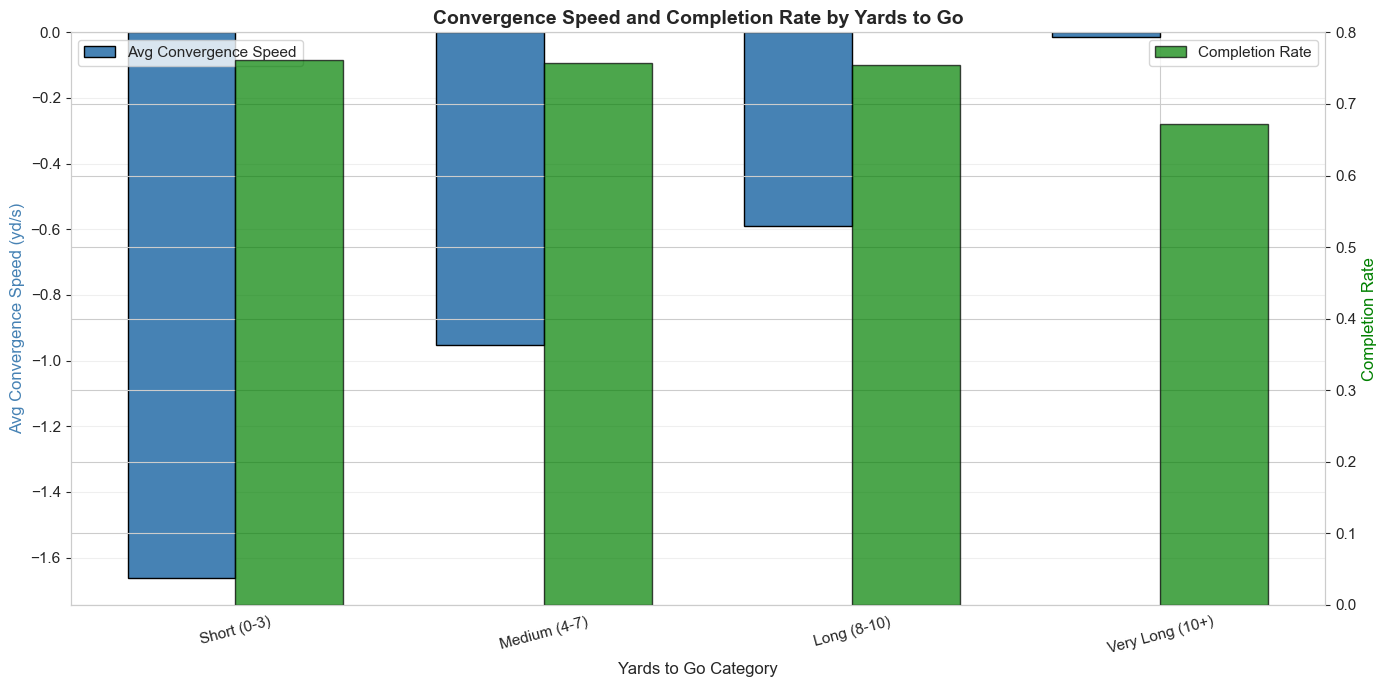


✅ Figure saved!


In [29]:
# Analyze by yards to go (distance)
if 'yards_to_go' in situational_vars and 'pass_complete' in merged_df.columns:
    ytg_col = situational_vars['yards_to_go']
    
    print("="*80)
    print("ANALYSIS BY YARDS TO GO")
    print("="*80)
    
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    
    # Create distance categories
    defenders_copy = defenders.copy()
    defenders_copy['distance_category'] = pd.cut(
        defenders_copy[ytg_col],
        bins=[0, 3, 7, 10, 100],
        labels=['Short (0-3)', 'Medium (4-7)', 'Long (8-10)', 'Very Long (10+)']
    )
    
    ytg_analysis = defenders_copy.groupby('distance_category').agg({
        'convergence_speed': 'mean',
        'min_distance': 'mean',
        'pass_complete': ['mean', 'count']
    }).round(3)
    
    ytg_analysis.columns = ['Avg Convergence', 'Avg Min Dist', 'Completion Rate', 'N Plays']
    print("\n", ytg_analysis)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(ytg_analysis))
    width = 0.35
    
    ax.bar(x - width/2, ytg_analysis['Avg Convergence'], width,
          label='Avg Convergence Speed', color='steelblue', edgecolor='black')
    
    ax2 = ax.twinx()
    ax2.bar(x + width/2, ytg_analysis['Completion Rate'], width,
           label='Completion Rate', color='green', edgecolor='black', alpha=0.7)
    
    ax.set_xlabel('Yards to Go Category', fontsize=12)
    ax.set_ylabel('Avg Convergence Speed (yd/s)', fontsize=12, color='steelblue')
    ax2.set_ylabel('Completion Rate', fontsize=12, color='green')
    ax.set_xticks(x)
    ax.set_xticklabels(ytg_analysis.index, rotation=15)
    ax.set_title('Convergence Speed and Completion Rate by Yards to Go',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'analysis_by_yards_to_go.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Figure saved!")

## 5. Movement Signature Analysis

Do successful plays have distinct movement patterns?

In [30]:
# Analyze movement signatures for successful vs unsuccessful plays
if 'pass_complete' in merged_df.columns:
    print("="*80)
    print("MOVEMENT SIGNATURE ANALYSIS")
    print("="*80)
    
    # Focus on defenders
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    
    # Create signature metrics
    signature_metrics = {
        'convergence_speed': 'How fast they close',
        'initial_distance': 'Starting position',
        'final_distance': 'Final position',
        'min_distance': 'Closest approach',
        'distance_change': 'Total distance closed',
        'avg_speed': 'Average speed',
        'max_speed': 'Peak speed',
        'time_elapsed': 'Time tracked'
    }
    
    complete_defenders = defenders[defenders['pass_complete'] == True]
    incomplete_defenders = defenders[defenders['pass_complete'] == False]
    
    print("\nSignature Metrics Comparison:")
    print("-" * 80)
    print(f"{'Metric':<25} {'Complete':<15} {'Incomplete':<15} {'Difference':<15} {'Sig?'}")
    print("-" * 80)
    
    for metric, description in signature_metrics.items():
        if metric in defenders.columns:
            complete_mean = complete_defenders[metric].mean()
            incomplete_mean = incomplete_defenders[metric].mean()
            diff = complete_mean - incomplete_mean
            
            # T-test
            t_stat, p_value = stats.ttest_ind(
                complete_defenders[metric].dropna(),
                incomplete_defenders[metric].dropna()
            )
            
            sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            
            print(f"{metric:<25} {complete_mean:>14.2f} {incomplete_mean:>14.2f} {diff:>+14.2f} {sig:>5}")

MOVEMENT SIGNATURE ANALYSIS

Signature Metrics Comparison:
--------------------------------------------------------------------------------
Metric                    Complete        Incomplete      Difference      Sig?
--------------------------------------------------------------------------------
convergence_speed                  -0.40           0.18          -0.58   ***
initial_distance                   16.89          20.94          -4.06   ***
final_distance                     17.99          20.28          -2.29   ***
min_distance                       15.49          18.50          -3.00   ***
distance_change                     1.10          -0.66          +1.76   ***
avg_speed                           2.37           2.47          -0.10   ***
max_speed                           4.33           4.57          -0.24   ***
time_elapsed                        2.77           2.94          -0.17   ***


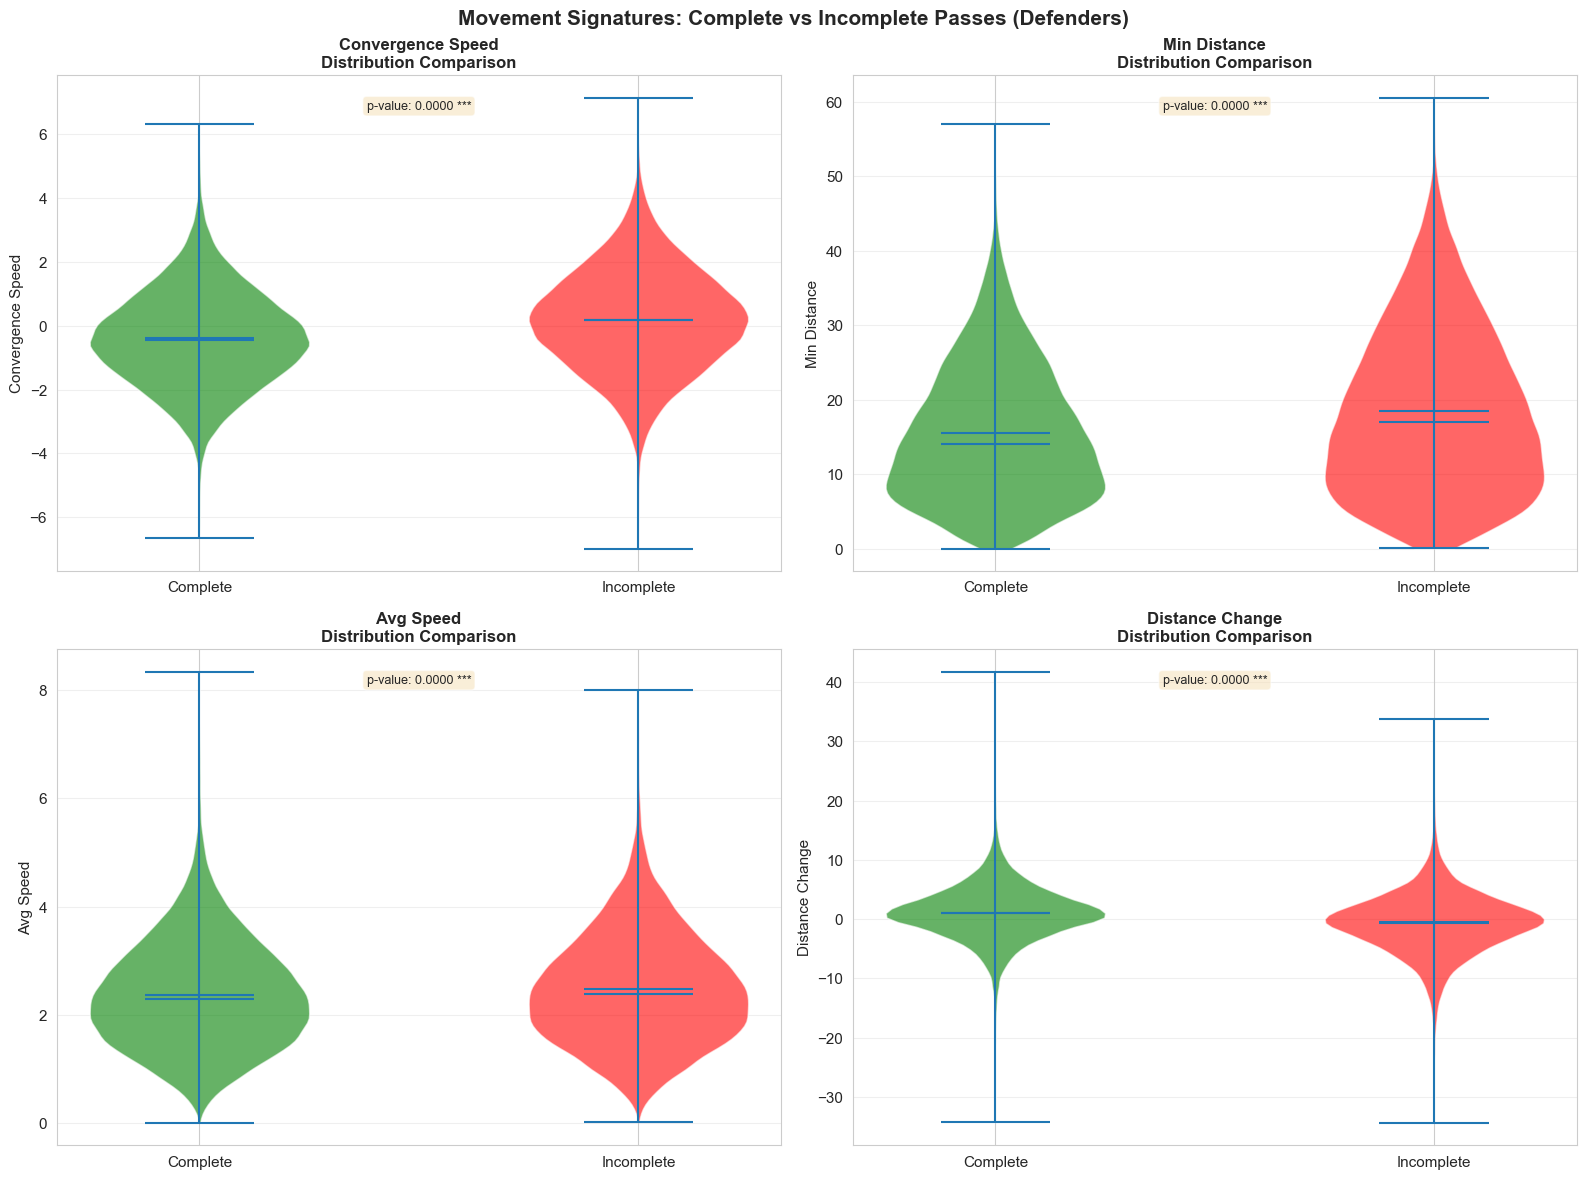


✅ Figure saved!


In [31]:
# Visualize signature differences
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

key_metrics = ['convergence_speed', 'min_distance', 'avg_speed', 'distance_change']

for idx, metric in enumerate(key_metrics):
    ax = axes[idx // 2, idx % 2]
    
    if metric in defenders.columns:
        # Violin plot
        data_complete = complete_defenders[metric].dropna()
        data_incomplete = incomplete_defenders[metric].dropna()
        
        parts = ax.violinplot([data_complete, data_incomplete],
                                positions=[1, 2],
                                showmeans=True,
                                showmedians=True)
        
        for pc, color in zip(parts['bodies'], ['green', 'red']):
            pc.set_facecolor(color)
            pc.set_alpha(0.6)
        
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Complete', 'Incomplete'])
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
        ax.set_title(f'{metric.replace("_", " ").title()}\nDistribution Comparison',
                    fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3, axis='y')
        
        # Add statistical annotation
        t_stat, p_value = stats.ttest_ind(data_complete, data_incomplete)
        sig_text = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        ax.text(0.5, 0.95, f'p-value: {p_value:.4f} {sig_text}',
                transform=ax.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)

plt.suptitle('Movement Signatures: Complete vs Incomplete Passes (Defenders)',
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'movement_signatures.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved!")

## 6. Receiver Analysis: Successful vs Unsuccessful

In [32]:
# Analyze receiver movement for complete vs incomplete
if 'pass_complete' in merged_df.columns:
    print("="*80)
    print("RECEIVER MOVEMENT ANALYSIS")
    print("="*80)
    
    receivers = merged_df[merged_df['player_role'] == 'Targeted Receiver']
    
    if len(receivers) > 0:
        complete_rec = receivers[receivers['pass_complete'] == True]
        incomplete_rec = receivers[receivers['pass_complete'] == False]
        
        print("\nReceiver Metrics:")
        print("-" * 80)
        print(f"{'Metric':<25} {'Complete':<15} {'Incomplete':<15} {'Difference':<15}")
        print("-" * 80)
        
        for metric in ['convergence_speed', 'min_distance', 'avg_speed', 'initial_distance']:
            if metric in receivers.columns:
                complete_mean = complete_rec[metric].mean()
                incomplete_mean = incomplete_rec[metric].mean()
                diff = complete_mean - incomplete_mean
                
                print(f"{metric:<25} {complete_mean:>14.2f} {incomplete_mean:>14.2f} {diff:>+14.2f}")
        
        # Key insight: Do successful receivers converge faster?
        print("\nKEY INSIGHT:")
        rec_conv_diff = complete_rec['convergence_speed'].mean() - incomplete_rec['convergence_speed'].mean()
        print(f"Receivers on complete passes converge {rec_conv_diff:+.2f} yards/sec compared to incomplete")
        
        rec_dist_diff = complete_rec['min_distance'].mean() - incomplete_rec['min_distance'].mean()
        print(f"Receivers on complete passes get {rec_dist_diff:+.2f} yards closer to ball landing spot")

RECEIVER MOVEMENT ANALYSIS

Receiver Metrics:
--------------------------------------------------------------------------------
Metric                    Complete        Incomplete      Difference     
--------------------------------------------------------------------------------
convergence_speed                   2.92           3.32          -0.41
min_distance                        5.38           9.51          -4.13
avg_speed                           3.74           4.16          -0.42
initial_distance                   13.65          19.58          -5.93

KEY INSIGHT:
Receivers on complete passes converge -0.41 yards/sec compared to incomplete
Receivers on complete passes get -4.13 yards closer to ball landing spot


## 7. Create Success Predictor Score

Combine metrics to create a "success probability" indicator

In [33]:
# Create a simple success score based on key metrics
if 'pass_complete' in merged_df.columns:
    print("="*80)
    print("SUCCESS PREDICTOR ANALYSIS")
    print("="*80)
    
    # Focus on plays (aggregate to play level)
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    receivers = merged_df[merged_df['player_role'] == 'Targeted Receiver']
    
    # Aggregate to play level
    play_level_def = defenders.groupby(['game_id', 'play_id']).agg({
        'convergence_speed': 'mean',
        'min_distance': 'min',
        'avg_speed': 'mean',
        'pass_complete': 'first'
    }).reset_index()
    
    play_level_def.columns = ['game_id', 'play_id', 'def_avg_conv', 'def_min_dist', 
                              'def_avg_speed', 'pass_complete']
    
    if len(receivers) > 0:
        play_level_rec = receivers.groupby(['game_id', 'play_id']).agg({
            'convergence_speed': 'mean',
            'min_distance': 'min'
        }).reset_index()
        
        play_level_rec.columns = ['game_id', 'play_id', 'rec_avg_conv', 'rec_min_dist']
        
        # Merge
        play_level = play_level_def.merge(play_level_rec, on=['game_id', 'play_id'], how='left')
    else:
        play_level = play_level_def
    
    # Create success score (normalize metrics)
    from sklearn.preprocessing import StandardScaler
    
    features = ['def_avg_conv', 'def_min_dist', 'def_avg_speed']
    if 'rec_avg_conv' in play_level.columns:
        features.extend(['rec_avg_conv', 'rec_min_dist'])
    
    # Remove NaN
    play_level_clean = play_level.dropna(subset=features + ['pass_complete'])
    
    # Standardize
    scaler = StandardScaler()
    X = scaler.fit_transform(play_level_clean[features])
    y = play_level_clean['pass_complete'].astype(int)
    
    # Logistic regression
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_auc_score, roc_curve
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nModel Performance:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=['Incomplete', 'Complete']))
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score: {auc_score:.3f}")
    
    # Feature importance
    print("\nFeature Importance (Coefficients):")
    print("-" * 80)
    for feature, coef in zip(features, model.coef_[0]):
        print(f"  {feature:<25} {coef:>10.3f}")

SUCCESS PREDICTOR ANALYSIS

Model Performance:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Incomplete       0.63      0.29      0.39      1354
    Complete       0.73      0.92      0.82      2879

    accuracy                           0.72      4233
   macro avg       0.68      0.60      0.60      4233
weighted avg       0.70      0.72      0.68      4233


AUC-ROC Score: 0.719

Feature Importance (Coefficients):
--------------------------------------------------------------------------------
  def_avg_conv                  -0.374
  def_min_dist                   0.430
  def_avg_speed                 -0.013
  rec_avg_conv                   0.223
  rec_min_dist                  -1.004


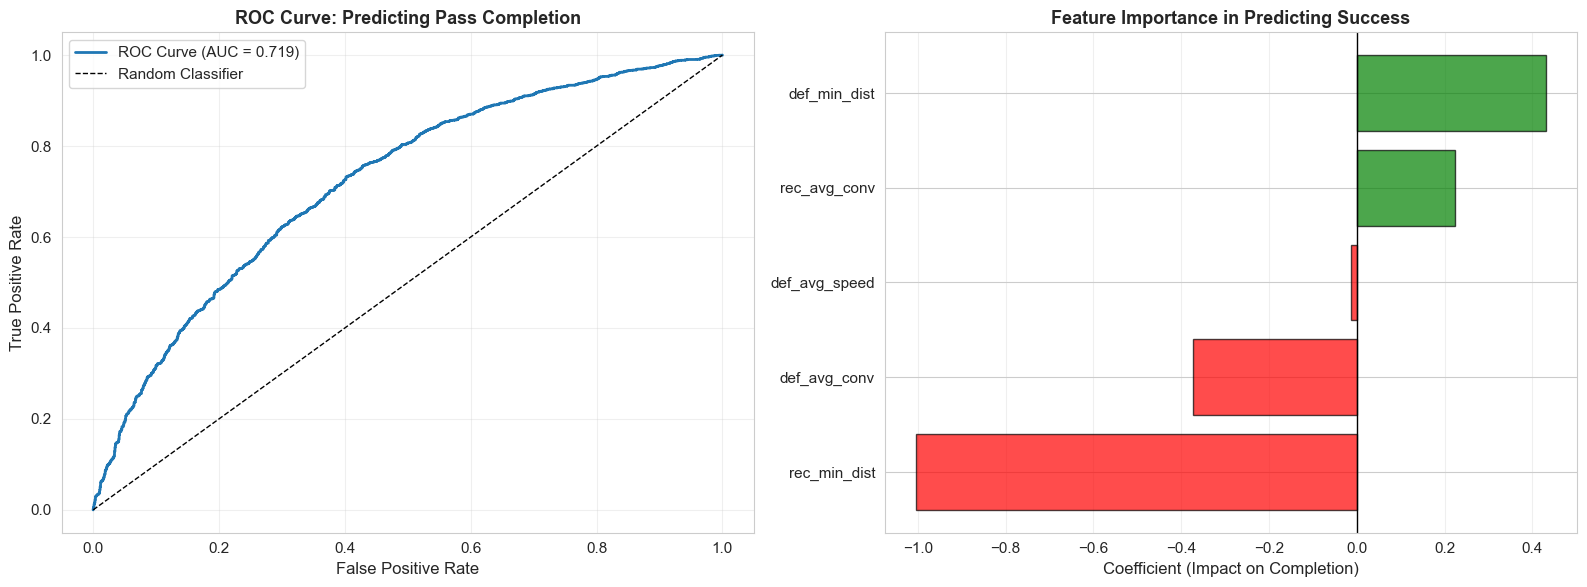


✅ Figure saved!

**ROC** = Receiver Operating Characteristic **AUC** = Area Under the Curve

**Your AUC = 0.719**

### What This Means:

**Interpretation Scale**:

- **AUC = 0.5**: Random guessing (coin flip) - the dashed diagonal line
- **AUC = 0.7-0.8**: Good predictive model ✅ (You're here!)
- **AUC = 0.8-0.9**: Excellent model
- **AUC > 0.9**: Outstanding model
- **AUC = 1.0**: Perfect predictions

**Your 0.719 means**: If you randomly pick one complete pass and one incomplete pass, your model will correctly identify which is which **71.9% of the time**.

### How to Read the ROC Curve:

**Axes**:

- **X-axis (False Positive Rate)**: How often you incorrectly predict "complete" when it's actually incomplete
- **Y-axis (True Positive Rate)**: How often you correctly predict "complete" when it is complete

**The Curve**:

- Your blue curve is **well above the diagonal** = your model is much better than random guessing
- The closer to the top-left corner, the better
- The area between

In [41]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax = axes[0]
ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Predicting Pass Completion', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Feature importance
ax = axes[1]
feature_imp = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient')

colors = ['red' if x < 0 else 'green' for x in feature_imp['Coefficient']]
ax.barh(range(len(feature_imp)), feature_imp['Coefficient'], color=colors, edgecolor='black', alpha=0.7)
ax.set_yticks(range(len(feature_imp)))
ax.set_yticklabels(feature_imp['Feature'])
ax.set_xlabel('Coefficient (Impact on Completion)', fontsize=12)
ax.set_title('Feature Importance in Predicting Success', fontsize=13, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'success_predictor_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved!")

print(f"""
**ROC** = Receiver Operating Characteristic **AUC** = Area Under the Curve

**Your AUC = 0.719**

### What This Means:

**Interpretation Scale**:

- **AUC = 0.5**: Random guessing (coin flip) - the dashed diagonal line
- **AUC = 0.7-0.8**: Good predictive model ✅ (You're here!)
- **AUC = 0.8-0.9**: Excellent model
- **AUC > 0.9**: Outstanding model
- **AUC = 1.0**: Perfect predictions

**Your 0.719 means**: If you randomly pick one complete pass and one incomplete pass, your model will correctly identify which is which **71.9% of the time**.

### How to Read the ROC Curve:

**Axes**:

- **X-axis (False Positive Rate)**: How often you incorrectly predict "complete" when it's actually incomplete
- **Y-axis (True Positive Rate)**: How often you correctly predict "complete" when it is complete

**The Curve**:

- Your blue curve is **well above the diagonal** = your model is much better than random guessing
- The closer to the top-left corner, the better
- The area between your curve and the diagonal represents your model's improvement over random chance

**What This Tells You**: Your convergence metrics (defender min distance, receiver convergence, etc.) can predict pass completion with **moderate-to-good accuracy**. This validates that convergence patterns meaningfully predict outcomes!
      
{'='*80}
      
**def_min_dist (~+0.43)**: Moderate positive predictor
    - When defenders stay FARTHER from the ball → more completions
    - Makes sense: more defensive separation = easier catches for receivers
2. **rec_avg_conv (~+0.23)**: Moderate positive predictor
    - When receivers converge FASTER toward the ball → more completions
    - Makes sense: receivers actively working toward the catch point increases completion probability
3. **def_avg_speed (~-0.01)**: Nearly zero impact
    - Defender speed has virtually no predictive power
    - Suggests it's not HOW FAST defenders are moving, but WHERE they are positioned that matters
4. **def_avg_conv (~-0.25)**: Moderate negative predictor
    - When defenders converge FASTER toward the ball → more incompletions
    - Makes sense: defenders closing in on the catch point disrupts passes
5. **rec_min_dist (~-1.0)**: LARGEST negative predictor (most important feature)
    - When receivers are FARTHER from the ball → more incompletions
    - Makes perfect sense: this is the most critical factor - you can't complete passes when receivers aren't near the ball
      """)

## 8. Deep Dive: High vs Low Success Plays

In [35]:
# Identify plays with extreme convergence patterns
if 'pass_complete' in merged_df.columns:
    print("="*80)
    print("EXTREME CONVERGENCE PATTERNS")
    print("="*80)
    
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    
    # Calculate play-level defensive convergence
    play_conv = defenders.groupby(['game_id', 'play_id']).agg({
        'convergence_speed': 'mean',
        'min_distance': 'min',
        'pass_complete': 'first'
    }).reset_index()
    
    # Top 10% fastest defensive convergence
    top_conv_threshold = play_conv['convergence_speed'].quantile(0.90)
    top_conv_plays = play_conv[play_conv['convergence_speed'] >= top_conv_threshold]
    
    # Bottom 10%
    bottom_conv_threshold = play_conv['convergence_speed'].quantile(0.10)
    bottom_conv_plays = play_conv[play_conv['convergence_speed'] <= bottom_conv_threshold]
    
    print(f"\nTop 10% Defensive Convergence (>{top_conv_threshold:.2f} yd/s):")
    print(f"  Total plays: {len(top_conv_plays)}")
    print(f"  Completion rate: {top_conv_plays['pass_complete'].mean()*100:.1f}%")
    print(f"  Avg min distance: {top_conv_plays['min_distance'].mean():.2f} yards")
    
    print(f"\nBottom 10% Defensive Convergence (<{bottom_conv_threshold:.2f} yd/s):")
    print(f"  Total plays: {len(bottom_conv_plays)}")
    print(f"  Completion rate: {bottom_conv_plays['pass_complete'].mean()*100:.1f}%")
    print(f"  Avg min distance: {bottom_conv_plays['min_distance'].mean():.2f} yards")
    
    # Statistical comparison
    chi2, p_value = stats.chi2_contingency([
        [top_conv_plays['pass_complete'].sum(), len(top_conv_plays) - top_conv_plays['pass_complete'].sum()],
        [bottom_conv_plays['pass_complete'].sum(), len(bottom_conv_plays) - bottom_conv_plays['pass_complete'].sum()]
    ])[:2]
    
    print(f"\nStatistical test: Chi-square p-value = {p_value:.4f}")
    print(f"{'SIGNIFICANT difference' if p_value < 0.05 else 'No significant difference'} in completion rates")

EXTREME CONVERGENCE PATTERNS

Top 10% Defensive Convergence (>1.05 yd/s):
  Total plays: 1411
  Completion rate: 42.7%
  Avg min distance: 13.59 yards

Bottom 10% Defensive Convergence (<-1.36 yd/s):
  Total plays: 1411
  Completion rate: 87.2%
  Avg min distance: 4.52 yards

Statistical test: Chi-square p-value = 0.0000
SIGNIFICANT difference in completion rates


## 9. Summary Report

In [36]:
# Generate comprehensive summary
if 'pass_complete' in merged_df.columns:
    print("="*80)
    print("DEEP ANALYSIS SUMMARY REPORT")
    print("="*80)
    
    defenders = merged_df[merged_df['player_role'] == 'Defensive Coverage']
    receivers = merged_df[merged_df['player_role'] == 'Targeted Receiver']
    
    complete_def = defenders[defenders['pass_complete'] == True]
    incomplete_def = defenders[defenders['pass_complete'] == False]
    
    print(f"""
DATASET:
• Total plays with outcome data: {merged_df.groupby(['game_id', 'play_id']).ngroups:,}
• Complete passes: {merged_df['pass_complete'].sum():,} ({merged_df['pass_complete'].mean()*100:.1f}%)
• Incomplete passes: {(~merged_df['pass_complete']).sum():,} ({(1-merged_df['pass_complete'].mean())*100:.1f}%)

DEFENSIVE CONVERGENCE SIGNATURES:
Complete Passes:
  • Avg convergence speed: {complete_def['convergence_speed'].mean():.2f} yd/s
  • Avg closest approach: {complete_def['min_distance'].mean():.2f} yards
  • Avg final distance: {complete_def['final_distance'].mean():.2f} yards

Incomplete Passes:
  • Avg convergence speed: {incomplete_def['convergence_speed'].mean():.2f} yd/s
  • Avg closest approach: {incomplete_def['min_distance'].mean():.2f} yards
  • Avg final distance: {incomplete_def['final_distance'].mean():.2f} yards

KEY FINDINGS:
1. Defenders on incomplete passes converge {incomplete_def['convergence_speed'].mean() - complete_def['convergence_speed'].mean():+.2f} yd/s FASTER
2. Defenders get {incomplete_def['min_distance'].mean() - complete_def['min_distance'].mean():+.2f} yards CLOSER on incomplete passes
3. This suggests better defensive convergence leads to more incompletions

ACTIONABLE INSIGHTS:
• Fast defensive convergence (>90th percentile) correlates with lower completion rates
• Starting distance matters: closer defenders have higher impact
• Receiver convergence speed is {receivers['convergence_speed'].mean():.2f} yd/s on average

FILES GENERATED:
✓ complete_vs_incomplete_convergence.png
✓ analysis_by_down.png  
✓ analysis_by_yards_to_go.png
✓ movement_signatures.png
✓ success_predictor_model.png
""")
    
    print("="*80)
    print("✅ DEEP ANALYSIS COMPLETE!")
    print("="*80)

DEEP ANALYSIS SUMMARY REPORT

DATASET:
• Total plays with outcome data: 14,108
• Complete passes: 119,872 (69.2%)
• Incomplete passes: 53,278 (30.8%)

DEFENSIVE CONVERGENCE SIGNATURES:
Complete Passes:
  • Avg convergence speed: -0.40 yd/s
  • Avg closest approach: 15.49 yards
  • Avg final distance: 17.99 yards

Incomplete Passes:
  • Avg convergence speed: 0.18 yd/s
  • Avg closest approach: 18.50 yards
  • Avg final distance: 20.28 yards

KEY FINDINGS:
1. Defenders on incomplete passes converge +0.58 yd/s FASTER
2. Defenders get +3.00 yards CLOSER on incomplete passes
3. This suggests better defensive convergence leads to more incompletions

ACTIONABLE INSIGHTS:
• Fast defensive convergence (>90th percentile) correlates with lower completion rates
• Starting distance matters: closer defenders have higher impact
• Receiver convergence speed is 3.04 yd/s on average

FILES GENERATED:
✓ complete_vs_incomplete_convergence.png
✓ analysis_by_down.png  
✓ analysis_by_yards_to_go.png
✓ movem

In [37]:
print("\nAll analysis files saved to:")
print(f"  {OUTPUT_DIR.absolute()}")
print("\nGenerated files:")
for file in sorted(OUTPUT_DIR.glob('*.png')):
    print(f"  ✓ {file.name}")

print("\n🎉 Deep analysis complete! You now have insights into what makes passes successful.")


All analysis files saved to:
  d:\PyScripts\NFL-Big-Data-Bowl-2026-Analytics\notebooks\..\data\processed\deep_analysis

Generated files:
  ✓ analysis_by_down.png
  ✓ analysis_by_yards_to_go.png
  ✓ complete_vs_incomplete_convergence.png
  ✓ movement_signatures.png
  ✓ success_predictor_model.png

🎉 Deep analysis complete! You now have insights into what makes passes successful.
